In [27]:
import os
import joblib
import pickle

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_tests
import pingouin as pg
from statsmodels.regression.mixed_linear_model import MixedLM

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u



plt.rcParams['pdf.fonttype']=42
ko_mice = stx.ymaze_sess_deets.ko_mice

ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
# ctrl_mice = [m for m in ctrl_mice if m not in ('mCherry6')]

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Left to do:

explicit speed matching of formation lap & average speed through field

comparison of COM shift after formation lap (fast shift followed by slow shift)
    looks like initial shift is more dramatic
    
plot speed vs shift conditional distributions
    




In [2]:
figdir = "/mnt/BigDisk/YMazeResults/neural/field_shifts"
os.makedirs(figdir,exist_ok=True)

In [3]:

def run_shuffle(sess, rng):
    spks = sess.timeseries['spks']
    spks_shuff = np.zeros(spks.shape)
    
    for trial, (start, stop) in enumerate(zip(sess.trial_start_inds, sess.teleport_inds)):
        _spks = 1*spks[:,start:stop]    
        _spks = np.roll(_spks,rng.integers(0,stop-start),axis=-1)
        spks_shuff[:,start:stop] = 1*_spks
        
    tmat = tpu.spatial_analyses.trial_matrix(spks_shuff.T,sess.timeseries['t'].ravel(), sess.trial_start_inds,
                                                                     sess.teleport_inds, min_pos=13, max_pos=43, bin_size=1, mat_only=True)
    
    nov_mean = np.nanmean(tmat[sess.trial_info['LR']==sess.novel_arm, :, :], axis=0)
    fam_mean = np.nanmean(tmat[sess.trial_info['LR']==-1*sess.novel_arm, :, :], axis=0)
    return nov_mean, fam_mean


rng = np.random.default_rng()
shuff_results = {}
for mice in (ctrl_mice, ko_mice):
    for mouse in mice:
        shuff_results[mouse]={}
        for day in range(6):
            shuff_results[mouse][day] = {}
            sess = u.load_single_day(mouse, day)
            shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(sess, rng) for i in range(1000)))
            print(shuff_trial_mat.shape)
            fam_shuff_thresh = np.nanpercentile(shuff_trial_mat[:, 1, :, :], 95, axis=0)
            nov_shuff_thresh = np.nanpercentile(shuff_trial_mat[:, 0, :, :], 95, axis=0)
            shuff_results[mouse][day]['fam']=fam_shuff_thresh
            shuff_results[mouse][day]['nov']=nov_shuff_thresh
            
            
            
    
# # cell = 0
# thresh_mat = np.zeros(sess.trial_matrices['spks'].shape[1:])
# for cell in range(spks.shape[-1]):
#     shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(sess, spks, rng, cell) for i in range(1000)))
#     cell_thresh = np.nanpercentile(shuff_trial_mat,95, axis=0)
#     thresh_mat[:,cell


{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}


Process LokyProcess-4:
Traceback (most recent call last):
  File "/home/mplitt/mambaforge/envs/STX3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/mplitt/mambaforge/envs/STX3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 443, in _process_worker
    _process_reference_size = _get_memory_usage(pid, force_gc=True)
  File "/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 108, in _get_memory_usage
    gc.collect()
KeyboardInterrupt
Process LokyProcess-13:
Traceback (most recent call last):
  File "/home/mplitt/mambaforge/envs/STX3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/mplitt/mambaforge/envs/STX3/lib/python3.8/multiprocessing/process.py", line 108, i

KeyboardInterrupt: 

In [9]:
import pickle
if False:
    with open('place_field_shuff_results.pkl','wb') as file:
        pickle.dump(shuff_results,file)

In [4]:
import pickle 
with open('place_field_shuff_results.pkl','rb') as file:
    shuff_results = pickle.load(file)

In [5]:
# shuff_results[ctrl_mice[0]][0]['fam']

def get_field_info(mouse, day, ttype):
    if mouse in ctrl_mice:
        cond = 'ctrl'
    else:
        cond = 'cre'
        
    sess = u.load_single_day(mouse, day)
    if ttype == 'fam':
        trial_mask = sess.trial_info['LR']==-1*sess.novel_arm
    elif ttype == 'nov':
        trial_mask = sess.trial_info['LR'] == sess.novel_arm
    else:
        pass

    # sess.add_pos_binned_trial_matrix('speed')

    trial_avg = np.nanmean(sess.trial_matrices['spks'][trial_mask, :, :],axis=0)
    sig_bins = trial_avg>shuff_results[mouse][day][ttype]

    # eliminate fields that start at first bin of track or end at last bin of track
    field_info = []

    ledges = np.argwhere(sig_bins[1:,:]>sig_bins[:-1,:])
    for _ledge in ledges:

        rem_trial = sig_bins[_ledge[0]:,_ledge[1]]
        _redge = np.argwhere(rem_trial[1:]<rem_trial[:-1])
        if (_redge.shape[0]>0) and (_redge[0][0]>2):
            
            place_field = sess.trial_matrices['spks'][trial_mask,  _ledge[0]:_ledge[0]+_redge[0][0], _ledge[1]]
            
            speed_field = sess.trial_matrices['speed'][trial_mask, _ledge[0]:_ledge[0]+_redge[0][0]]
            
            max_response = np.nanmax(place_field)
            place_field_filt = np.copy(place_field)
            place_field_filt[place_field<.2*max_response] = 0


            place_field_bool = 1*(np.nansum(place_field_filt, axis=-1)>0)
            place_field_bin_counts = sp.signal.convolve(place_field_bool,[1,1,1,1,1], mode='valid')



            thresh_laps = np.zeros(place_field_bool.shape)
            thresh_laps[:place_field_bin_counts.shape[0]] = 1*(place_field_bin_counts>=3)

            thresh_active_laps = np.argwhere(thresh_laps*place_field_bool)

            field_strength = np.nanmean(place_field,axis=-1)

            if thresh_active_laps.shape[0]>0:


                formation_lap = thresh_active_laps[0][0]
                pcnt_trials_active = np.nanmean(place_field_bool[formation_lap:])
                if pcnt_trials_active>.66:

                    # cell, left edge, right edge, formation lap, formation lap speed
                    field_info.append([_ledge[1], _ledge[0], _redge[0][0], formation_lap, np.nanmean(speed_field[formation_lap,:])])
                    
                    
    
    com_mat = np.nan*np.zeros([trial_mask.sum(), len(field_info)])
    maxact_mat = np.nan*np.zeros([trial_mask.sum(), len(field_info)])
    fs_mat = np.nan*np.zeros([trial_mask.sum(), len(field_info)])
    
    # df = {'mouse': [], 'cond':[], 'day':[], 'com':[], 'trial':[], 'cell': [], 'speed':[], 'ttype':[]}
    for c, (cell, l_edge, r_edge, formation_lap, _) in enumerate(field_info):
        # print(cell, l_edge, r_edge, formation_lap)

        place_field = sess.trial_matrices['spks'][trial_mask,  l_edge:l_edge+r_edge, cell]
        # fig,ax = plt.subplots(1,2, sharey=True)
        # ax[0].imshow(place_field[formation_lap:,:])

        com = []
        maxact = []
        starts = sess.trial_start_inds[trial_mask]
        stops = sess.teleport_inds[trial_mask]
        for t, (start, stop) in enumerate(zip(starts[formation_lap:], stops[formation_lap:])):
            
            pos = sess.timeseries['t'][0,start:stop]
            speed = sess.timeseries['speed'][0, start:stop]
            spks = np.copy(sess.timeseries['spks'][cell,start:stop])
            # spks[spks<.2*np.nanmax(sess.timeseries['spks'][cell,:])] = 0

            mask = (pos>(l_edge + sess.trial_matrices['bin_edges'][0])) & (pos<(l_edge+r_edge + sess.trial_matrices['bin_edges'][0])) & (speed>2)
            if mask.sum()>0:
                pos = pos[mask]
                spks = spks[mask]

                com.append((pos*spks).sum()/(spks.sum()+1E-5))
                maxact.append(pos[np.argmax(spks)])
                
            else:
                com.append(np.nan)
                maxact.append(np.nan)
            
        com_mat[:len(com), c] = np.array(com)
        maxact_mat[:len(maxact),c] = np.array(maxact)

    return field_info, com_mat, fs_mat, maxact_mat#, pd.DataFrame(df)



field_stats = {}
df = []
for mouse in (ctrl_mice+ko_mice):
    field_stats[mouse] = {}
    for day in range(6):
        field_stats[mouse][day]={}
        for ttype in ('fam', 'nov'):
            field_stats[mouse][day][ttype]={}
            
            # field_info, com_mat, fs_mat, _df  = get_field_info(mouse, day, ttype)
            field_info, com_mat, fs_mat, maxact_mat  = get_field_info(mouse, day, ttype)
            # df.append(_df)
            field_stats[mouse][day][ttype]['field_info'] = field_info
            field_stats[mouse][day][ttype]['com'] = com_mat
            field_stats[mouse][day][ttype]['field_strength'] = fs_mat
            field_stats[mouse][day][ttype]['maxact'] = maxact_mat
            
# df = pd.DataFrame(df)

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel'

/tmp/ipykernel_2650149/1006561375.py:51: RuntimeWarning: Mean of empty slice
  field_strength = np.nanmean(place_field,axis=-1)


{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 3})
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:97: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'sessi

/tmp/ipykernel_2650149/1006561375.py:51: RuntimeWarning: Mean of empty slice
  field_strength = np.nanmean(place_field,axis=-1)


{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'sessi

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 

In [32]:
df = {'mouse': [],
      'cond': [],
      'ttype': [],
      'day': [],
      'field_width': [],
      'n_fields': []}
      

lw = 5
s = 10

for cond, mice in zip(('ctrl', 'cre'), (ctrl_mice,ko_mice)):
    for mouse in mice:
        for day in range(6):
            for ttype in ('fam', 'nov'):
                df['mouse'].append(mouse)
                df['cond'].append(cond)
                df['ttype'].append(ttype)
                df['day'].append(day)

                f_info = np.array(field_stats[mouse][day][ttype]['field_info'])

                df['field_width'].append(f_info[:,2].mean())
                cell_list = np.unique(f_info[:,0])
                df['n_fields'].append(np.array([np.count_nonzero(f_info[:,0]==cell) for cell in cell_list]).mean())
df = pd.DataFrame(df)

In [33]:
df.head()

,mouse,cond,ttype,day,field_width,n_fields
0,4467331.1,ctrl,fam,0,7.844538,1.084282
1,4467331.1,ctrl,nov,0,6.073952,1.317100
2,4467331.1,ctrl,fam,1,8.924107,1.069212
3,4467331.1,ctrl,nov,1,6.680540,1.193289
4,4467331.1,ctrl,fam,2,7.384270,1.123737


        Source         SS  DF1  DF2         MS          F     p-unc       np2  \
0         cond  21.314247    1   14  21.314247  23.399959  0.000263  0.625668   
1          day   4.087158    5   70   0.817432   8.427737  0.000003  0.375773   
2  Interaction   0.967986    5   70   0.193597   1.995992  0.089844  0.124781   

       eps  
0      NaN  
1  0.73324  
2      NaN  
      Contrast day    A     B Paired  Parametric         T        dof  \
0          day   -    0     1   True        True -0.776270  15.000000   
1          day   -    0     2   True        True  0.032776  15.000000   
2          day   -    0     3   True        True -1.919538  15.000000   
3          day   -    0     4   True        True -1.292291  15.000000   
4          day   -    0     5   True        True -4.340638  15.000000   
5          day   -    1     2   True        True  0.871883  15.000000   
6          day   -    1     3   True        True -0.852020  15.000000   
7          day   -    1     4   True   

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "B"] = B
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:583: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the ol

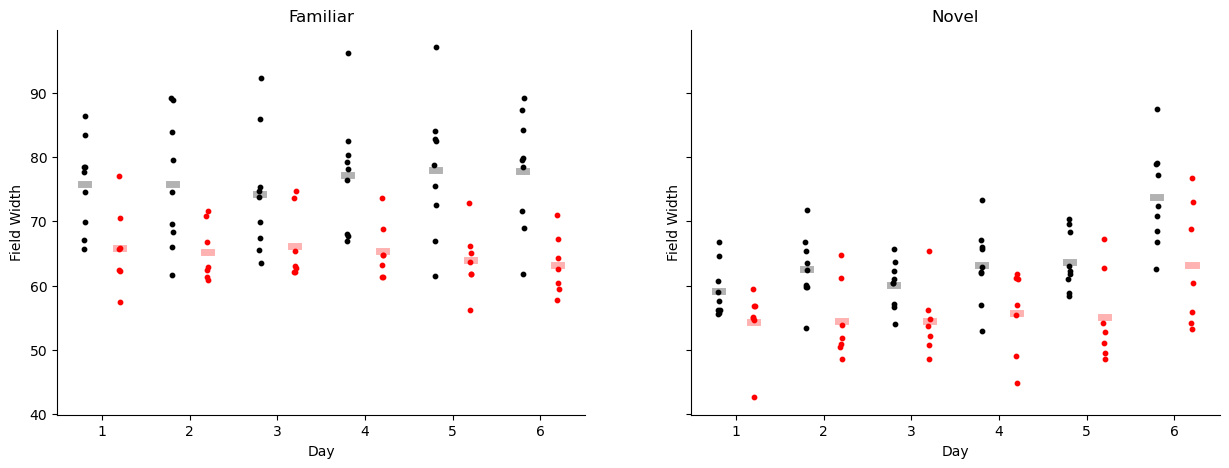

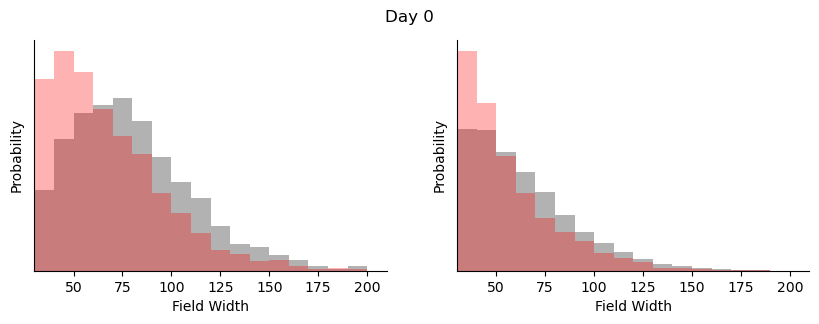

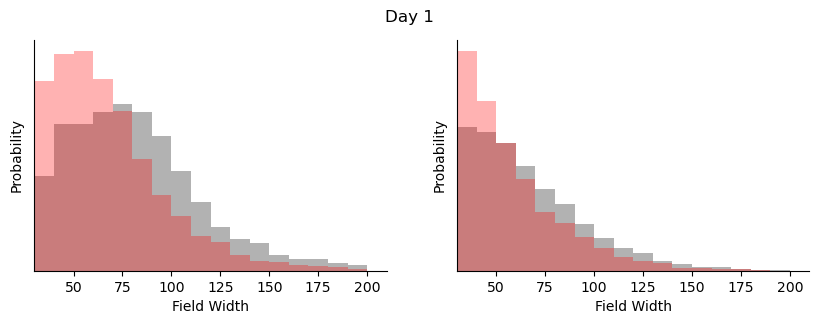

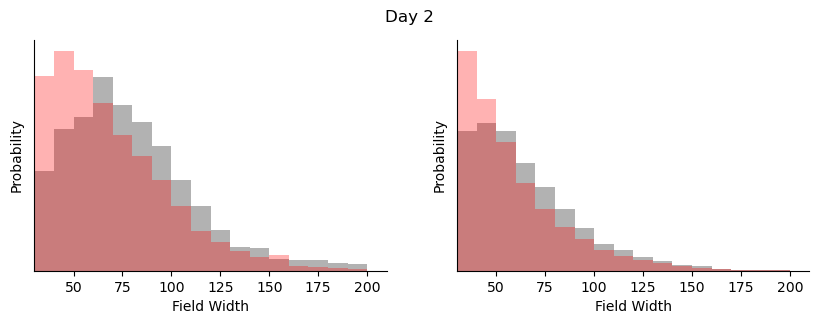

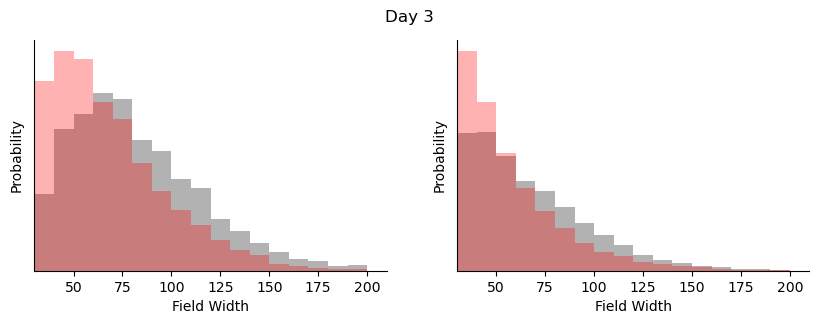

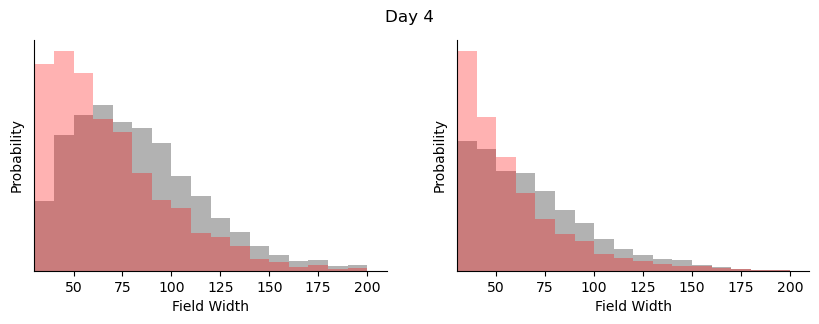

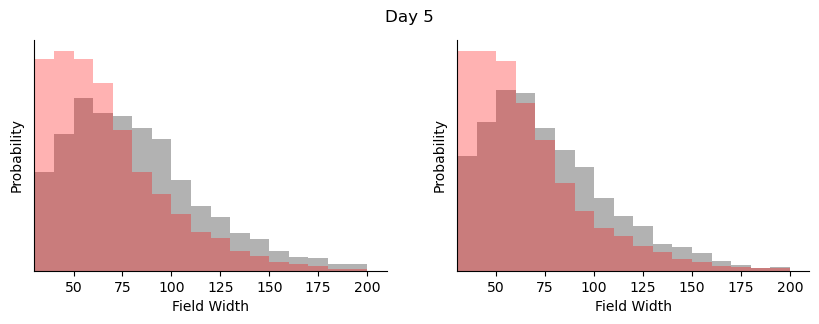

In [51]:
fig, ax = plt.subplots(1,2, figsize=[15,5], sharey=True)

# population plots
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='fam')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[0].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='black', s=s)
    ax[0].plot(5*day -1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='nov')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[1].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='black', s=s, alpha = 1)
    ax[1].plot(5*day -1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='fam')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[0].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='red', s=s)
    ax[0].plot(5*day + 1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='nov')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[1].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='red', s=s, alpha=1)
    ax[1].plot(5*day + 1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    

ax[0].set_title('Familiar')
ax[1].set_title('Novel')
    
for a in range(2):

    ax[a].set_xticks(np.arange(0,6*5,5))
    ax[a].set_xticklabels([x for x in range(1,7)])

    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_ylabel('Field Width')
    ax[a].set_xlabel('Day')
fig.savefig(os.path.join(figdir, "field_width_across_mouse_summary.pdf"))


# single day, across mouse histograms
bin_edges = np.arange(30,210, 10)
for day in range(6):
    fig, ax = plt.subplots(1,2, figsize = [10,3])
    fig.suptitle(f'Day {day}')
    for ax_ind, ttype in enumerate(('fam', 'nov')):
        
        ctrl_width = []
        for mouse in ctrl_mice:
            f_info = 10*np.array(field_stats[mouse][day][ttype]['field_info'])
            ctrl_width.append(f_info[:,2].ravel())
            
        ctrl_width = np.concatenate(ctrl_width)
        
        ax[ax_ind].hist(ctrl_width, bins=bin_edges, color='black', alpha=.3, density=True)
        
        ko_width = []
        for mouse in ko_mice:
            f_info = 10*np.array(field_stats[mouse][day][ttype]['field_info'])
            ko_width.append(f_info[:,2].ravel())
            
        ko_width = np.concatenate(ko_width)
        ax[ax_ind].hist(ko_width, bins=bin_edges, color='red', alpha=.3, density=True)
        

        ax[ax_ind].spines['top'].set_visible(False)
        ax[ax_ind].spines['right'].set_visible(False)
    
        ax[ax_ind].set_yticks([])
        ax[ax_ind].set_ylabel('Probability')
        ax[ax_ind].set_xlabel('Field Width')
        ax[ax_ind].set_xlim(30,210)
        
        fig.savefig(os.path.join(figdir, f"day{day}_field_width_hist.pdf"))


aov = mixed_anova(data=df, dv='field_width', between='cond', within='day', subject='mouse')
print(aov)

posthoc = pairwise_tests(data=df, dv='field_width', between='cond', within='day', subject='mouse', padjust = 'holm')
print(posthoc)


        Source        SS  DF1  DF2        MS          F         p-unc  \
0         cond  0.251424    1   14  0.251424  19.483278  5.887567e-04   
1          day  0.074529    5   70  0.014906  12.031867  2.019337e-08   
2  Interaction  0.023495    5   70  0.004699   3.793028  4.256198e-03   

        np2       eps  
0  0.581881       NaN  
1  0.462198  0.638032  
2  0.213175       NaN  
      Contrast day    A     B Paired  Parametric         T        dof  \
0          day   -    0     1   True        True -0.357510  15.000000   
1          day   -    0     2   True        True -1.169739  15.000000   
2          day   -    0     3   True        True -0.733965  15.000000   
3          day   -    0     4   True        True -0.958747  15.000000   
4          day   -    0     5   True        True  4.861699  15.000000   
5          day   -    1     2   True        True -0.938361  15.000000   
6          day   -    1     3   True        True -0.621990  15.000000   
7          day   -    1    

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "B"] = B
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:583: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the ol

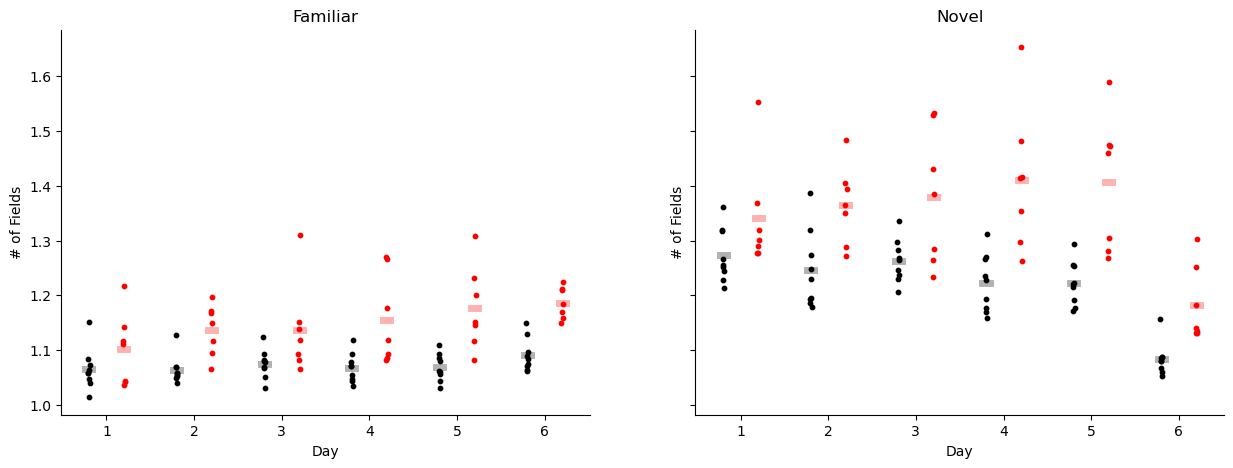

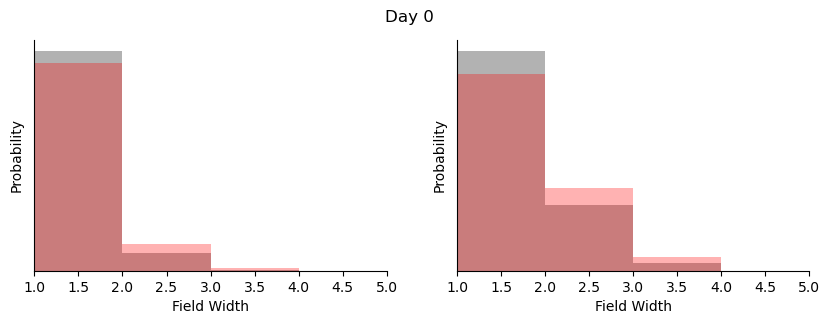

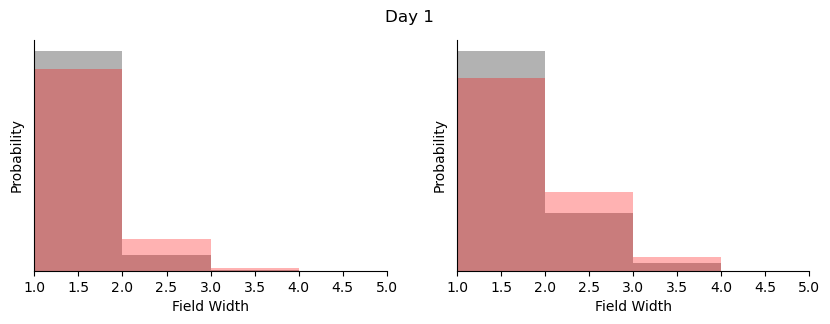

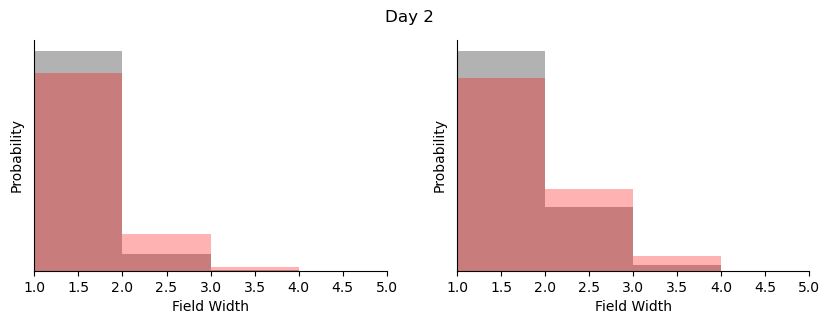

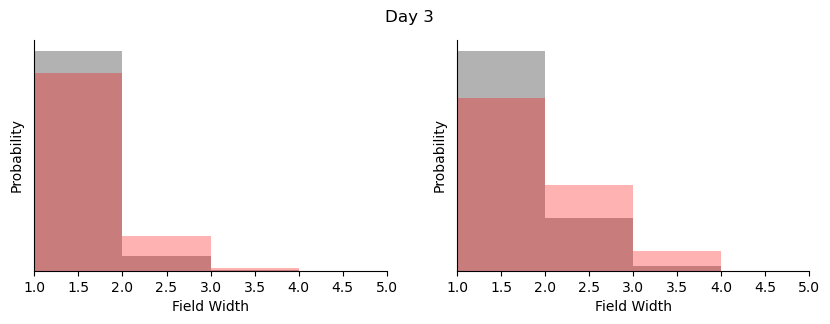

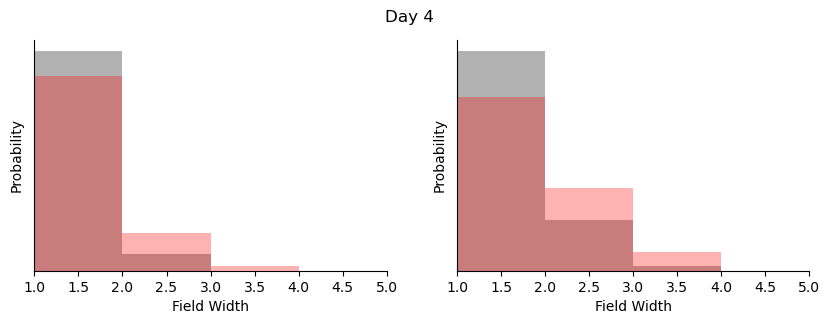

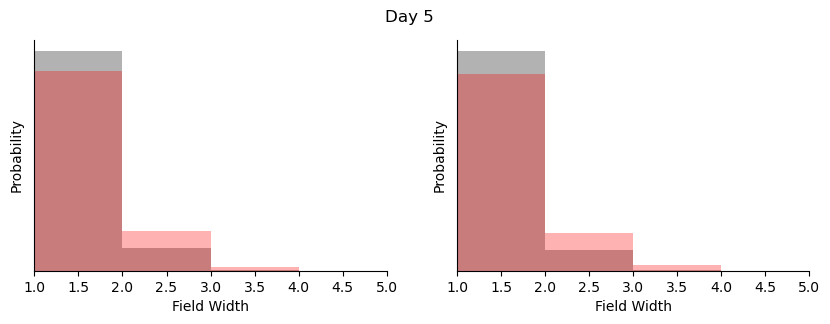

In [52]:
fig, ax = plt.subplots(1,2, figsize=[15,5], sharey=True)

# population plots
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='fam')
    nf = df['n_fields'].loc[mask]._values
    ax[0].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='black', s=s)
    ax[0].plot(5*day -1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='nov')
    nf = df['n_fields'].loc[mask]._values
    ax[1].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='black', s=s, alpha = 1)
    ax[1].plot(5*day -1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='fam')
    nf = df['n_fields'].loc[mask]._values
    ax[0].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='red', s=s)
    ax[0].plot(5*day + 1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='nov')
    nf = df['n_fields'].loc[mask]._values
    ax[1].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='red', s=s, alpha=1)
    ax[1].plot(5*day + 1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    

ax[0].set_title('Familiar')
ax[1].set_title('Novel')
    
for a in range(2):

    ax[a].set_xticks(np.arange(0,6*5,5))
    ax[a].set_xticklabels([x for x in range(1,7)])

    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_ylabel('# of Fields')
    ax[a].set_xlabel('Day')
fig.savefig(os.path.join(figdir, "num_fields_across_mouse_summary.pdf"))



# single day, across mouse histograms
bin_edges = np.arange(0,5, 1)
for day in range(6):
    fig, ax = plt.subplots(1,2, figsize = [10,3])
    fig.suptitle(f'Day {day}')
    for ax_ind, ttype in enumerate(('fam', 'nov')):
        
        ctrl_width = []
        for mouse in ctrl_mice:
            f_info = 10*np.array(field_stats[mouse][day][ttype]['field_info'])
            cell_list = np.unique(f_info[:,0])
            
            ctrl_width.append(np.array([np.count_nonzero(f_info[:,0]==cell) for cell in cell_list]).ravel())
            
            
        ctrl_width = np.concatenate(ctrl_width)
        
        ax[ax_ind].hist(ctrl_width, bins=bin_edges, color='black', alpha=.3, density=True)
        
        ko_width = []
        for mouse in ko_mice:
            f_info = 10*np.array(field_stats[mouse][day][ttype]['field_info'])
            cell_list = np.unique(f_info[:,0])
                
            ko_width.append(np.array([np.count_nonzero(f_info[:,0]==cell) for cell in cell_list]).ravel())
            
        ko_width = np.concatenate(ko_width)
        ax[ax_ind].hist(ko_width, bins=bin_edges, color='red', alpha=.3, density=True)
        

        ax[ax_ind].spines['top'].set_visible(False)
        ax[ax_ind].spines['right'].set_visible(False)
    
        ax[ax_ind].set_yticks([])
        ax[ax_ind].set_ylabel('Probability')
        ax[ax_ind].set_xlabel('Field Width')
        ax[ax_ind].set_xlim(1,5)
        
        fig.savefig(os.path.join(figdir, f"day{day}_num_fields_hist.pdf"))


aov = mixed_anova(data=df, dv='n_fields', between='cond', within='day', subject='mouse')
print(aov)

posthoc = pairwise_tests(data=df, dv='n_fields', between='cond', within='day', subject='mouse', padjust = 'holm')
print(posthoc)


/tmp/ipykernel_2640313/2849650131.py:31: RuntimeWarning: Mean of empty slice
  mu, sem = np.nanmean(ctrl_com,axis=0), sp.stats.sem(ctrl_com,axis=0, nan_policy='omit')
/tmp/ipykernel_2640313/2849650131.py:60: RuntimeWarning: Mean of empty slice
  mu, sem = np.nanmean(ko_com,axis=0), sp.stats.sem(ko_com,axis=0, nan_policy='omit')


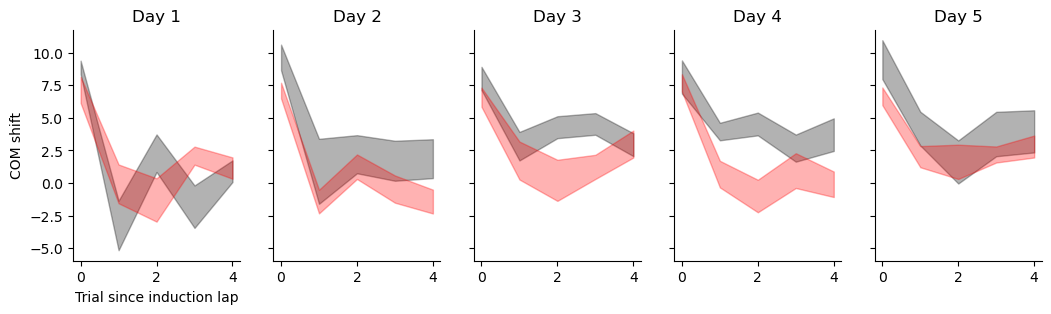

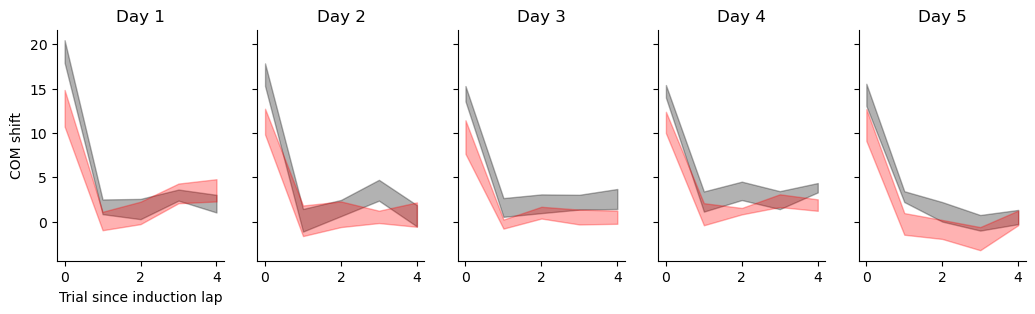

In [14]:

max_trial=140 #5
plot_max = 5
# ttype = 'nov'
df = {'mouse': [], 'cond':[], 'day':[], 'shift':[], 'nov':[]}
for ttype in ('fam', 'nov'):
    fig, ax = plt.subplots(1,5, sharey=True, figsize=[12.5,3])
    for day in range(5):
        # com = []
        ctrl_com = np.nan*np.zeros((len(ctrl_mice),max_trial))
        for m, mouse in enumerate(ctrl_mice):
            _com = field_stats[mouse][day][ttype]['com']
            # _com = field_stats[mouse][day][ttype]['maxact']
            # print(_com.shape)
            field_info = np.array(field_stats[mouse][day][ttype]['field_info'])
            # _com = _com - _com[:1,:]
            _com = (_com - np.nanmean(_com[1:,:], axis=0,keepdims=True))
            # print(np.isnan(_com).sum())
            ctrl_com[m,:_com.shape[0]] = 10*np.nanmean(_com, axis=-1)
            # com.append(np.nanmean(_com[:max_trial,:], axis=-1))

            df['mouse'].append(mouse)
            df['cond'].append('ctrl')
            df['day'].append(day)
            # df['shift'].append(np.nanmean(np.nanmean(_com, axis=-1)[1:]))
            df['shift'].append(10*np.nanmean(_com[0,:]))
            df['nov'].append(ttype)

            # ax[day].scatter(np.arange(_com.shape[0]), 10*np.nanmean(_com[:,:], axis=-1), color='black')

        # ctrl_com = 10*np.array(com)
        mu, sem = np.nanmean(ctrl_com,axis=0), sp.stats.sem(ctrl_com,axis=0, nan_policy='omit')           
        # ax[day].fill_between(np.arange(max_trial), mu+sem, mu-sem, color='black', alpha=.3) 
        ax[day].fill_between(np.arange(plot_max), mu[:plot_max]+sem[:plot_max], mu[:plot_max]-sem[:plot_max], color='black', alpha=.3) 

        # com = []
        ko_com = np.nan*np.zeros((len(ko_mice), max_trial))
        for m, mouse in enumerate(ko_mice):
            _com = field_stats[mouse][day][ttype]['com']
            # _com = field_stats[mouse][day][ttype]['maxact']
            # print(_com.shape)
            # _com = _com - _com[:1,:]
            field_info = np.array(field_stats[mouse][day][ttype]['field_info'])
            _com = (_com - np.nanmean(_com[1:,:],axis=0,keepdims=True))
            # print(np.isnan(_com).sum())
            # com.append(np.nanmean(_com[:max_trial,:], axis=-1))
            ko_com[m,:_com.shape[0]] = 10*np.nanmean(_com, axis=-1)

            df['mouse'].append(mouse)
            df['cond'].append('cre')
            df['day'].append(day)
            # df['shift'].append(np.nanmean(np.nanmean(_com, axis=-1)[1:]))
            df['shift'].append(10*np.nanmean(_com[0,:]))
            df['nov'].append(ttype)


            # ax[day].scatter(np.arange(_com.shape[0])+.2, 10*np.nanmean(_com[:,:], axis=-1), color='red')


        # ko_com = 10*np.array(com)
        mu, sem = np.nanmean(ko_com,axis=0), sp.stats.sem(ko_com,axis=0, nan_policy='omit')           
        ax[day].fill_between(np.arange(plot_max), mu[:plot_max]+sem[:plot_max], mu[:plot_max]-sem[:plot_max], color='red', alpha=.3) 


        ax[day].spines['top'].set_visible(False)
        ax[day].spines['right'].set_visible(False)
        ax[day].set_title(f'Day {day+1}')


        # for t in range(0, max_trial):
        #     t, p = sp.stats.ttest_ind(ctrl_com[:,t], ko_com[:,t])
        #     print(t,p)

        ax[0].set_ylabel('COM shift')
        ax[0].set_xlabel('Trial since induction lap')
        

        fig.savefig(os.path.join(figdir, f"single_field_COM_shift_maxtrial_{plot_max}_ttype_{ttype}.pdf"))
df = pd.DataFrame(df)

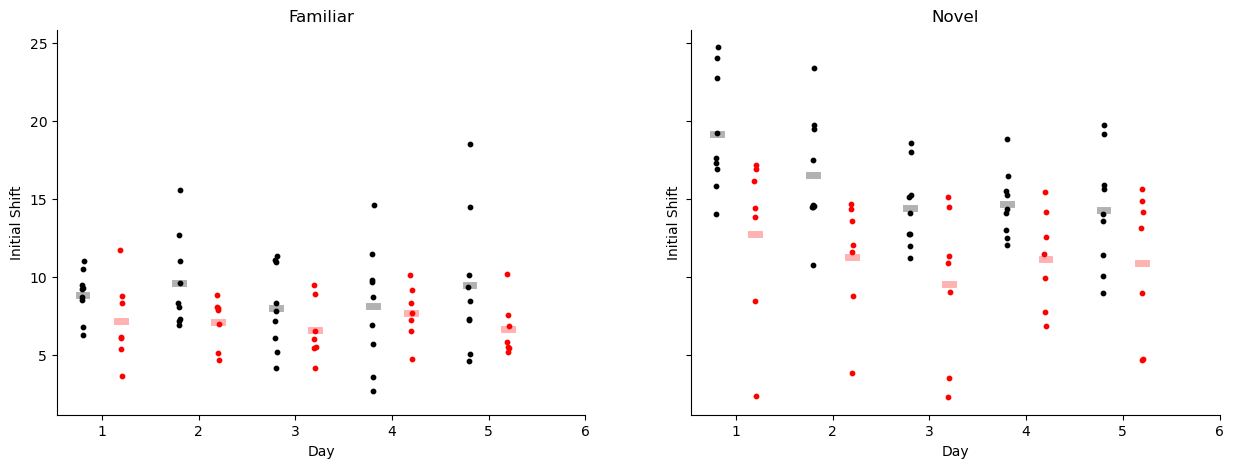

In [15]:
# summary plot 
fig, ax = plt.subplots(1,2, figsize=[15,5], sharey=True)

lw = 5
s = 10
key = 'shift'
for day in range(5):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['nov']=='fam')
    lr = df[key].loc[mask]._values
    ax[0].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='black', s=s)
    ax[0].plot(5*day -1 + np.array([-0.2, .2]), lr.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['nov']=='nov')
    lr = df[key].loc[mask]._values
    ax[1].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='black', s=s, alpha = 1)
    ax[1].plot(5*day -1 + np.array([-0.2, .2]), lr.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['nov']=='fam')
    lr = df[key].loc[mask]._values
    ax[0].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='red', s=s)
    ax[0].plot(5*day + 1 + np.array([-0.2, .2]), lr.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day)& (df['nov']=='nov')
    lr = df[key].loc[mask]._values
    ax[1].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='red', s=s, alpha=1)
    ax[1].plot(5*day + 1 + np.array([-0.2, .2]), lr.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
ax[0].set_title('Familiar')
ax[1].set_title('Novel')
    
for a in range(2):

    ax[a].set_xticks(np.arange(0,6*5,5))
    ax[a].set_xticklabels([x for x in range(1,7)])

    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_ylabel('Initial Shift')
    ax[a].set_xlabel('Day')

fig.savefig(os.path.join(figdir, 'famnov_init_shift_summary.pdf'))



In [16]:
ddf = df[(df['day']<6) & (df['nov']=='nov') ]
aov = mixed_anova(data=ddf, dv='shift', between='cond', within='day', subject='mouse')
print(aov)
stats = pg.pairwise_tests(data=ddf, dv='shift', between='cond', within='day', subject='mouse', padjust='holm')
print(stats)

        Source          SS  DF1  DF2          MS         F     p-unc  \
0         cond  433.695882    1   14  433.695882  9.028621  0.009462   
1          day  168.660679    4   56   42.165170  6.291282  0.000297   
2  Interaction   25.088647    4   56    6.272162  0.935842  0.449968   

        np2       eps  
0  0.392061       NaN  
1  0.310049  0.772167  
2  0.062657       NaN  
      Contrast day    A     B Paired  Parametric         T        dof  \
0          day   -    0     1   True        True  3.191850  15.000000   
1          day   -    0     2   True        True  5.343027  15.000000   
2          day   -    0     3   True        True  2.958537  15.000000   
3          day   -    0     4   True        True  3.392919  15.000000   
4          day   -    1     2   True        True  2.411954  15.000000   
5          day   -    1     3   True        True  1.091818  15.000000   
6          day   -    1     4   True        True  1.972320  15.000000   
7          day   -    2     3  

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "B"] = B
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:583: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the ol

(14, 14)
(14, 1)
(14, 14)
(14, 1)
(14, 14)
(14, 1)
(14, 14)
(14, 1)
(14, 14)


/tmp/ipykernel_2502217/3926487811.py:66: RuntimeWarning: invalid value encountered in divide
  COM = (H_ctrl*shift_bins[np.newaxis,1:]).sum(axis=1,keepdims=True)/(H_ctrl.sum(axis=1)[:, np.newaxis])
/tmp/ipykernel_2502217/3926487811.py:67: RuntimeWarning: invalid value encountered in divide
  COM = COM - (H_ko*shift_bins[np.newaxis,1:]).sum(axis=1,keepdims=True)/(H_ko.sum(axis=1)[:, np.newaxis])


(14, 1)
(14, 14)
(14, 1)


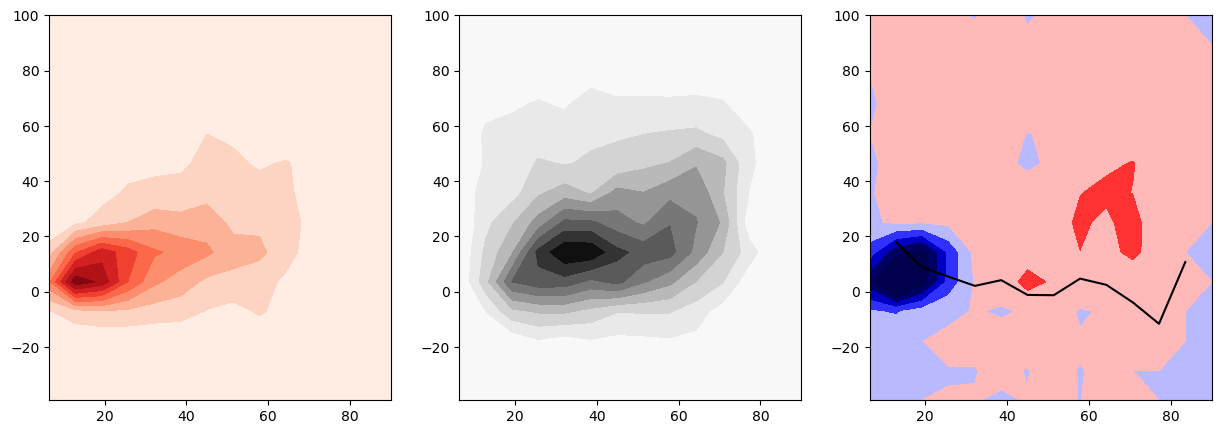

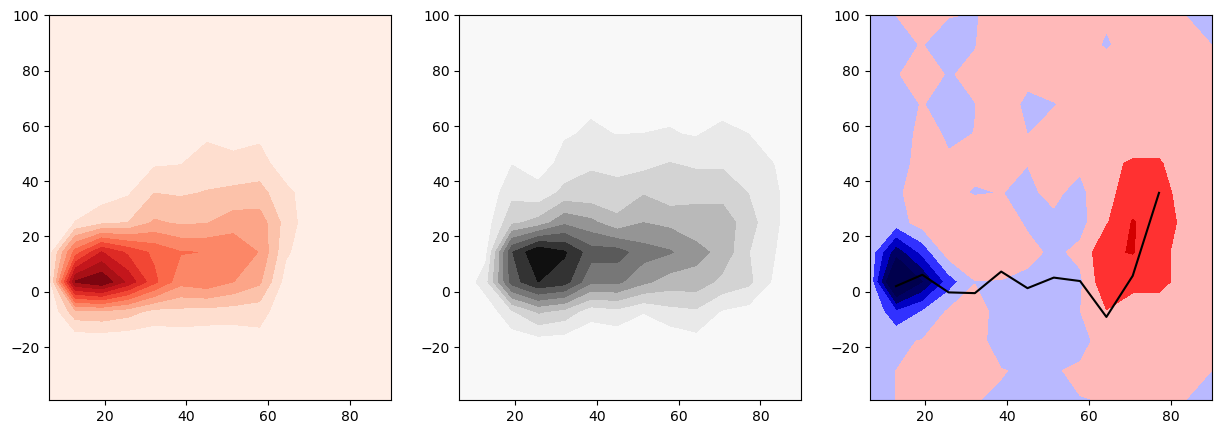

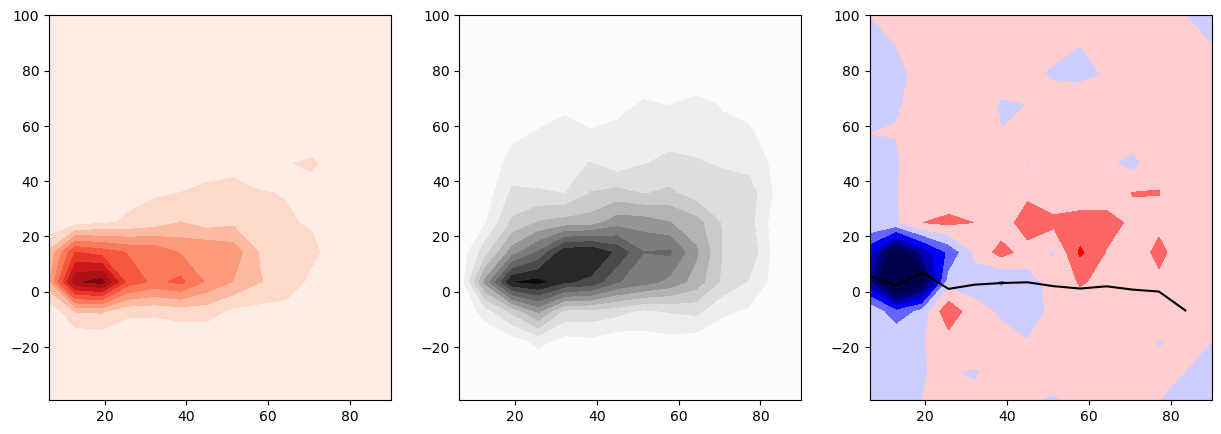

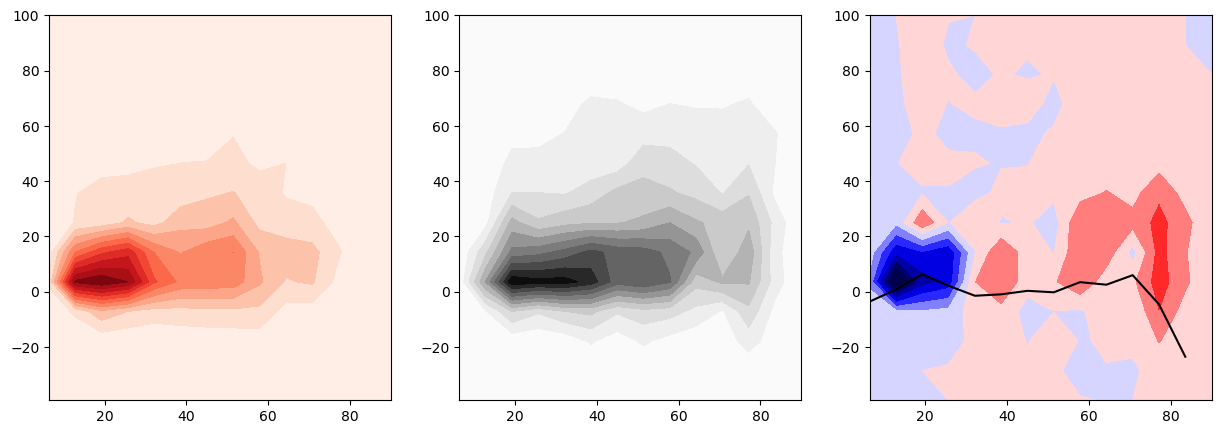

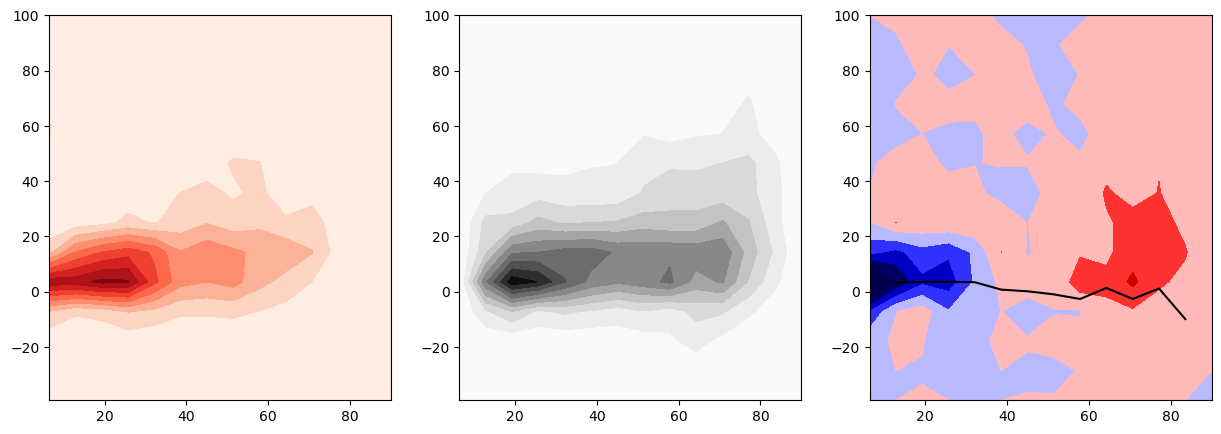

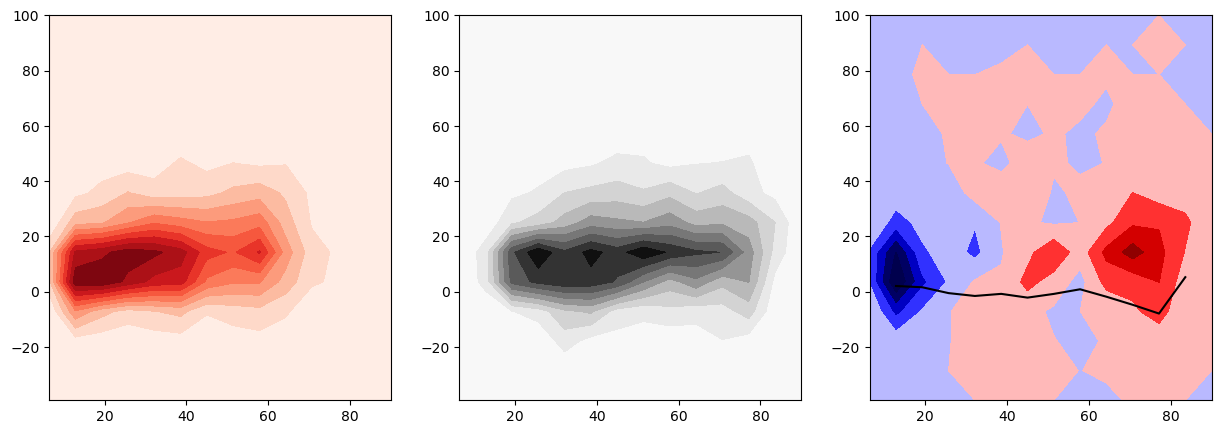

In [135]:

day = 0
ttype= 'nov'

for day in range(6):
    shift, speed = [], []
    for mouse in ko_mice:

        field_info = field_stats[mouse][day][ttype]['field_info']
        com = field_stats[mouse][day][ttype]['com']
        com = com - np.nanmean(com[1:,:],axis=0, keepdims=True)
        shift.append(10*com[0,:])
        speed.append(np.array(field_info)[:,-1])

    shift = np.concatenate(shift)
    speed = np.concatenate(speed)

    # print(shift.shape)

    mask = ~np.isnan(shift) & (shift>-50) & (speed>1) & (shift<200) & (speed<80)
    fig, ax = plt.subplots(1,3,figsize=[15,5]) #,sharey=True, sharex=True, )
    speed_bins = np.linspace(0, 90, num=15)
    shift_bins = np.linspace(-50,100, num=15)
    X,Y = np.meshgrid(speed_bins[1:], shift_bins[1:])
    # ax[0].scatter(speed[mask], shift[mask], color ='red', s=2, alpha=.3)
    # ax[0].plot(speed_bins, 0*speed_bins, color='blue')

    H, _, _ = np.histogram2d(speed[mask], shift[mask], bins = [speed_bins,shift_bins], density=True)
    H_ko =np.copy(H)
    H_ko = H_ko/(H_ko.sum(axis=1, keepdims=True)+1E-3)
    print(H.shape)
    # ax[0].imshow((H/(H.sum(axis=1,keepdims=True)+1E-3)).T, vmin=0, vmax=.2, cmap='Reds')
    ax[0].contourf(X, Y, H_ko.T, 10, cmap='Reds')
    # ax[0].hist2d(speed[mask], shift[mask], bins=[speed_bins, shift_bins], cmap='PuRd', density=True, vmax=.01)
    # res = sp.stats.pearsonr(speed[mask],shift[mask])
    # print(res)

    shift, speed = [], []
    for mouse in ctrl_mice:


        field_info = field_stats[mouse][day][ttype]['field_info']
        com = field_stats[mouse][day][ttype]['com']
        com = com - np.nanmean(com[1:,:],axis=0, keepdims=True)
        shift.append(10*com[0,:])
        speed.append(np.array(field_info)[:,-1])

    shift = np.concatenate(shift)
    speed = np.concatenate(speed)

    # print(shift.shape)

    mask = ~np.isnan(shift) & (shift>-50) & (speed>1) & (shift<200) & (speed<80)
    H, _, _ = np.histogram2d(speed[mask], shift[mask], bins = [speed_bins,shift_bins], density=True)
    H_ctrl = np.copy(H)
    H_ctrl = H_ctrl/(H_ctrl.sum(axis=1, keepdims=True)+1E-3)
    # ax[1].imshow((H/(H.sum(axis=1,keepdims=True)+1E-3)).T, vmin=0, vmax=.2, cmap='Greys')
    ax[1].contourf(X, Y, H_ctrl.T, 10, cmap='Greys')
    # ax[1].hist2d(speed[mask], shift[mask], bins=[speed_bins,shift_bins], cmap='PuRd', density=True, vmax=.01)
    # ax[1].scatter(speed[mask], shift[mask], color ='black', s=2, alpha=.3)
    # ax[1].plot(speed_bins, 0*speed_bins, color='blue')
    res = sp.stats.pearsonr(speed[mask],shift[mask])
    
    # ax[2].imshow((H_ctrl-H_ko).T, vmin=-.3, vmax=.3, cmap='seismic')
    ax[2].contourf(X, Y, (H_ctrl-H_ko).T, 10, cmap='seismic', vmin=-.15, vmax=.15)
    diff = H_ctrl-H_ko
    COM = (H_ctrl*shift_bins[np.newaxis,1:]).sum(axis=1,keepdims=True)/(H_ctrl.sum(axis=1)[:, np.newaxis])
    COM = COM - (H_ko*shift_bins[np.newaxis,1:]).sum(axis=1,keepdims=True)/(H_ko.sum(axis=1)[:, np.newaxis])
    # COM = (diff*shift_bins[np.newaxis,1:]).sum(axis=1, keepdims=True)/diff.sum(axis=1)[:,np.newaxis]
    print(COM.shape)
    ax[2].plot(speed_bins[1:], COM, color='black')
    ax[2].plot(speed_bins[1:],0*speed_bins[1:], color='blue', zorder=-1)

# print(res)

In [19]:
df = {'mouse':[], 'cond': [], 'ttype': [], 'day':[], 'shift': [], 'speed': []}

for cond, mice in zip(('ctrl', 'cre'), (ctrl_mice, ko_mice)):
    
    for mouse in mice:
        
        for day in range(6):
            for ttype in ('nov','fam'):
                field_info = field_stats[mouse][day][ttype]['field_info']
                
                com = field_stats[mouse][day][ttype]['com']
                com = com - np.nanmean(com[1:,:],axis=0, keepdims=True)
    
    
                for f, field in enumerate(field_info):
                    # cell, left edge, right edge, formation lap, formation lap speed
                    df['mouse'].append(mouse)
                    df['cond'].append(cond)
                    df['ttype'].append(ttype)
                    df['day'].append(day)
                    df['shift'].append(10*com[0, f])
                    df['speed'].append(field[-1])
                    
                    
df = pd.DataFrame(df)
            # print(mouse, day, len(field_info))
            # com = field_stats[mouse][day][ttype]['com']
            # com = com - com[:1,:]
            # shift.append(com[1,:])
            # speed.append(np.array(field_info)[:,-1])


In [20]:
import statsmodels.formula.api as smf

ddf = df[(df['ttype']=='nov') * (df['day']<5)]# * (df['speed']<60) * (df['speed']>10)]
model = smf.mixedlm('shift ~ speed*C(cond)*C(day)', ddf, groups = 'mouse').fit()
model = smf.mixedlm('shift ~ speed*C(cond)*C(day)', ddf, groups = 'mouse').fit(start_params=model.params)
# results = model.fit()

print(model.summary())
print(model.wald_test_terms())

                   Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       shift       
No. Observations:       73486         Method:                   REML        
No. Groups:             16            Scale:                    459.5411    
Min. group size:        1854          Log-Likelihood:           -329566.4746
Max. group size:        9964          Converged:                Yes         
Mean group size:        4592.9                                              
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          3.813    0.902  4.228 0.000  2.045  5.580
C(cond)[T.ctrl]                    7.538    1.280  5.889 0.000  5.029 10.047
C(day)[T.1]                        0.419    0.783  0.535 0.593 -1.115  1.953
C(day)[T.2]        

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/base/model.py:1889: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


In [22]:
import statsmodels.formula.api as smf

ddf = df[(df['ttype']=='nov') * (df['day']==0)]# * (df['speed']<60) * (df['speed']>20)]
model = smf.mixedlm('shift ~ speed*C(cond)', ddf, groups = 'mouse').fit()
model = smf.mixedlm('shift ~ speed*C(cond)', ddf, groups = 'mouse').fit(start_params=model.params)
# results = model.fit()

print(model.summary())
print(model.wald_test_terms(scalar=True))

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   shift      
No. Observations:    14517     Method:               REML       
No. Groups:          16        Scale:                530.5217   
Min. group size:     272       Log-Likelihood:       -66162.8165
Max. group size:     2040      Converged:            Yes        
Mean group size:     907.3                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              7.007    1.553  4.512 0.000  3.963 10.051
C(cond)[T.ctrl]        5.370    2.070  2.594 0.009  1.313  9.426
speed                  0.191    0.027  7.175 0.000  0.139  0.244
speed:C(cond)[T.ctrl] -0.026    0.032 -0.829 0.407 -0.089  0.036
mouse Var             11.650    0.203                           

                    chi2        P>chi2

In [23]:
model.params.keys()

Index(['Intercept', 'C(cond)[T.ctrl]', 'speed', 'speed:C(cond)[T.ctrl]',
       'mouse Var'],
      dtype='object')

(14, 14)


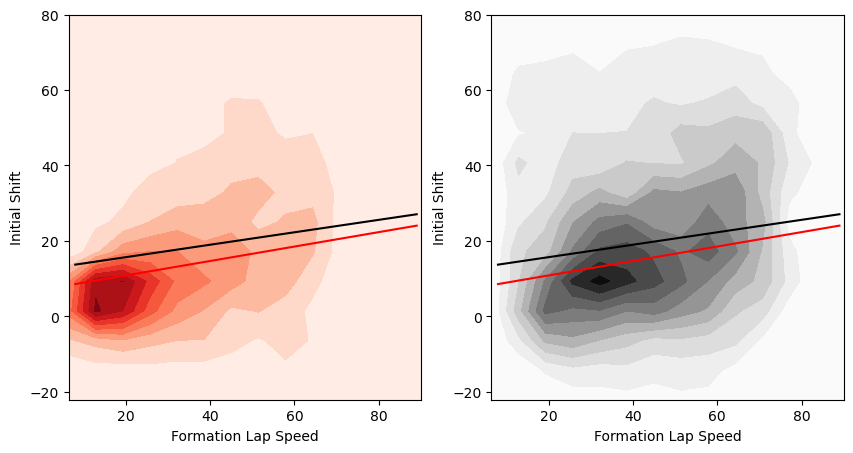

In [25]:
ttype= 'nov'
day = 0

shift, speed = [], []
for mouse in ko_mice:

    field_info = field_stats[mouse][day][ttype]['field_info']
    com = field_stats[mouse][day][ttype]['com']
    com = com - np.nanmean(com[1:,:],axis=0, keepdims=True)
    shift.append(10*com[0,:])
    speed.append(np.array(field_info)[:,-1])

shift = np.concatenate(shift)
speed = np.concatenate(speed)

# print(shift.shape)

mask = ~np.isnan(shift) & (shift>-50) & (speed>1) & (shift<200) & (speed<80)
fig, ax = plt.subplots(1,2,figsize=[10,5]) #,sharey=True, sharex=True, )
speed_bins = np.linspace(0, 90, num=15)
shift_bins = np.linspace(-30,80, num=15)
X,Y = np.meshgrid(speed_bins[1:], shift_bins[1:])
# ax[0].scatter(speed[mask], shift[mask], color ='red', s=2, alpha=.3)
# ax[0].plot(speed_bins, 0*speed_bins, color='blue')

H, _, _ = np.histogram2d(speed[mask], shift[mask], bins = [speed_bins,shift_bins], density=True)
H_ko =np.copy(H)
H_ko = H_ko/(H_ko.sum(axis=1, keepdims=True)+1E-3)
print(H.shape)
# ax[0].imshow((H/(H.sum(axis=1,keepdims=True)+1E-3)).T, vmin=0, vmax=.2, cmap='Reds')
ax[0].contourf(X, Y, H_ko.T, 10, cmap='Reds')
# ax[0].hist2d(speed[mask], shift[mask], bins=[speed_bins, shift_bins], cmap='PuRd', density=True, vmax=.01)
# res = sp.stats.pearsonr(speed[mask],shift[mask])
# print(res)

shift, speed = [], []
for mouse in ctrl_mice:


    field_info = field_stats[mouse][day][ttype]['field_info']
    com = field_stats[mouse][day][ttype]['com']
    com = com - np.nanmean(com[1:,:],axis=0, keepdims=True)
    shift.append(10*com[0,:])
    speed.append(np.array(field_info)[:,-1])

shift = np.concatenate(shift)
speed = np.concatenate(speed)



mask = ~np.isnan(shift) & (shift>-50) & (speed>1) & (shift<200) & (speed<80)
H, _, _ = np.histogram2d(speed[mask], shift[mask], bins = [speed_bins,shift_bins], density=True)
H_ctrl = np.copy(H)
H_ctrl = H_ctrl/(H_ctrl.sum(axis=1, keepdims=True)+1E-3)

ax[1].contourf(X, Y, H_ctrl.T, 10, cmap='Greys')

res = sp.stats.pearsonr(speed[mask],shift[mask])

trials = np.arange(8,90)
y_cre = model.params['Intercept'] + model.params['speed']*trials
y_ctrl = model.params['Intercept'] + model.params['C(cond)[T.ctrl]'] + (model.params['speed']+model.params['speed:C(cond)[T.ctrl]'])*trials 
ax[0].plot(trials, y_cre, color='red')
ax[0].plot(trials, y_ctrl, color='black')

ax[0].set_xlabel('Formation Lap Speed')
ax[0].set_ylabel('Initial Shift')

ax[1].plot(trials, y_cre, color='red')
ax[1].plot(trials, y_ctrl, color='black')

ax[1].set_xlabel('Formation Lap Speed')
ax[1].set_ylabel('Initial Shift')

fig.savefig(os.path.join(figdir, f"shift_vs_speed_day{day}.pdf"))


In [162]:
df.head

<bound method NDFrame.head of             mouse  cond ttype  day     shift      speed
0       4467331.1  ctrl   nov    0  2.026325  49.749644
1       4467331.1  ctrl   nov    0  0.760758  49.044837
2       4467331.1  ctrl   nov    0  1.991123  46.304698
3       4467331.1  ctrl   nov    0  0.246813  45.543564
4       4467331.1  ctrl   nov    0 -2.809353  48.303798
...           ...   ...   ...  ...       ...        ...
121933       Cre9   cre   fam    5  4.305235  41.347871
121934       Cre9   cre   fam    5  1.135960  10.795451
121935       Cre9   cre   fam    5  3.489809  11.142558
121936       Cre9   cre   fam    5  1.103631   9.744437
121937       Cre9   cre   fam    5  3.357128  37.853484

[121938 rows x 6 columns]>

In [ ]:
# slope for shift over trials after formation lap

In [ ]:
#                 fig, ax = plt.subplots(1,5, figsize = [8,4], sharey=True)
#                 # formation_lap = formation_lap[0]
#                 # print(formation_lap)

#                 ax[0].imshow(sess.trial_matrices['spks'][trial_mask, :, _ledge[1]], cmap='magma', aspect = 'auto')
#                 ax[1].imshow(sess.trial_matrices['spks'][trial_mask, _ledge[0]:_ledge[0]+_redge[0][0], _ledge[1]], cmap='magma', aspect = 'auto')

#                 ax[2].imshow(place_field_filt, cmap='magma', aspect='auto')

#                 # ax[3].plot(place_field_bool, np.arange(place_field.shape[0]))
#                 # ax[3].plot(place_field_bin_counts,np.arange(place_field_bin_counts.shape[0]))
#                 ax[3].plot(field_strength[formation_lap:], np.arange(formation_lap, place_field.shape[0]))

#                 com = np.nansum(place_field*np.arange(place_field.shape[1])[np.newaxis,:], axis=-1)/(np.nansum(place_field,axis=-1)+1E-5)
#                 # com = np.array([sp.ndimage.center_of_mass(place_field[t, :]) for t in range(formation_lap, place_field.shape[0])])
#                 ax[4].plot(com[formation_lap:], np.arange(formation_lap, place_field.shape[0]))
#                 fig.suptitle(f'{thresh_active_laps[0]}')


# field_info = np.array(field_info)
com_mat = np.nan*np.zeros([trial_mask.sum(), len(field_info)])
fs_mat = np.nan*np.zeros([trial_mask.sum(), len(field_info)])

for i, field in enumerate(field_info):
    
    field_mat = sess.trial_matrices['spks'][trial_mask, field[1]:field[2], field[0]]
    field_mat = field_mat[field[3]:,:]
    
    fs = np.nanmean(field_mat,axis=-1)
    com = np.nansum(field_mat*np.arange(field_mat.shape[1])[np.newaxis,:], axis=-1)/(np.nansum(field_mat, axis=-1) + 1E-5)/(field_mat.shape[1]-1)
    
    com_mat[:com.shape[0],i] = com
    fs_mat[:fs.shape[0], i] = fs
    
    
fig, ax = plt.subplots()    
mu, sem = np.nanmean(com_mat, axis=-1), sp.stats.sem(com_mat, axis=-1, nan_policy='omit')
# max_trial = 10
ax.fill_between(np.arange(5), mu[:5]+sem[:5], mu[:5]-sem[:5], alpha=.3)
ax.plot(np.nanmean(com_mat[:5,:], axis=-1))
    

    # print(_ledge)

# find fields >= 30 cm
# ledges = 
# print(sig_bins.shape)

In [87]:
field_info.shape



(47, 4)

In [7]:
trial_mat_thresh = np.nanpercentile(shuff_trial_mat,95,axis=0)
trial_mat_thresh.shape

(30, 1381)

In [8]:
np.save('place_field_shuff_results.npy', shuff_trial_mat)

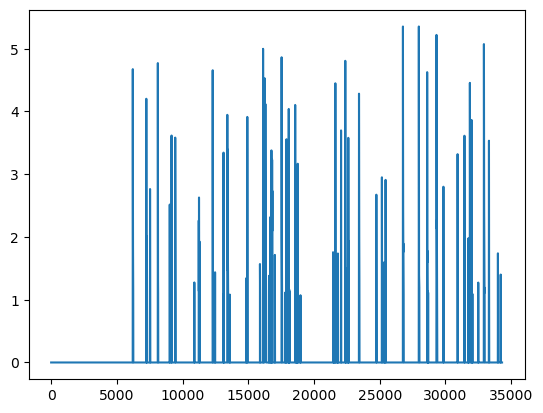

In [19]:
fig, ax = plt.subplots()
ax.plot(spks_shuff[0,:])